# Tahu lah apa ini?

In [1]:
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, VotingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from pyod.models.hbos import HBOS
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, OutlierMixin
from scipy.spatial.distance import mahalanobis

In [3]:
# Load the dataset
# file_path = '01.Dataset-Rofiqul/agriculture_dataset.csv'
# file_path = '01.Dataset-Rofiqul/Ujicoba3-29052024/agriculture_dataset.csv'
# file_path = 'dataset/agriculture_dataset.csv'
# file_path = 'dataset/09_05_1_AgricultureOutliersResult_30052024.csv'
# file_path = 'dataset/09_05_3_0_AgricultureOutliersDetectionResults.csv'
# file_path = 'dataset/09_05_3_2_AgricultureOutliersVotingBasedResult.csv'
file_path = 'dataset/09_05_4_1_AgricultureOutliers_HardVotingBased_IDO.csv'
data= pd.read_csv(file_path)




In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
hard=data[data['majority_voting']==1]
soft=data[data['average_voting']==1]

In [6]:
# Count the number of outliers and non-outliers for each voting method
hard_outlier_count = hard[hard['majority_voting'] == -1].shape[0]
hard_non_outlier_count = hard[hard['majority_voting'] == 1].shape[0]

soft_outlier_count = soft[soft['average_voting'] == -1].shape[0]
soft_non_outlier_count = soft[soft['average_voting'] == 1].shape[0]
print(f"Hard Voting - Number of outliers: {hard_outlier_count}")
print(f"Hard Voting - Number of non-outliers: {hard_non_outlier_count}")

print(f"Soft Voting - Number of outliers: {soft_outlier_count}")
print(f"Soft Voting - Number of non-outliers: {soft_non_outlier_count}")

Hard Voting - Number of outliers: 0
Hard Voting - Number of non-outliers: 2072
Soft Voting - Number of outliers: 0
Soft Voting - Number of non-outliers: 2072


In [7]:
# Summary of outliers detection
outlier_summary = {
    'Method': ['Isolation Forest', 'DBSCAN', 'One-Class SVM'],
    'Outliers': [
        np.sum(hard['if_outlier'] == -1),
        np.sum(hard['dbscan_outlier'] == -1),
        np.sum(hard['ocsvm_outlier'] == -1),
    ],
    'Inliers': [
        np.sum(hard['if_outlier'] == 1),
        np.sum(hard['dbscan_outlier'] == 1),
        np.sum(hard['ocsvm_outlier'] == 1),
    ]
}
summary_df = pd.DataFrame(outlier_summary)
summary_df

,Method,Outliers,Inliers
0,Isolation Forest,51,2021
1,DBSCAN,0,2072
2,One-Class SVM,50,2022


## Prepare Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Preprocess the data
features = hard.drop(columns=['N2O'])  # Assuming 'N2O' is the target column
target = hard['N2O']

# Encode categorical variables if any
label_encoders = {}
for column in features.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    features[column] = label_encoders[column].fit_transform(features[column])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Define X and y
X = scaled_features
y = target

In [10]:
def train_and_evaluate(test_size):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Initialize the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Size: {test_size}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R-squared: {r2}")

     # Create a single figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the actual vs predicted values
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], color='blue')
    axes[0].set_xlabel('Actual N2O')
    axes[0].set_ylabel('Predicted N2O')
    axes[0].set_title(f'Actual vs Predicted N2O (Test Size: {test_size})')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot residuals
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, ax=axes[1], color='green')
    axes[1].set_xlabel('Residuals')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'Residuals Distribution (Test Size: {test_size})')
    axes[1].tick_params(axis='x', rotation=45)

    # Plot feature importance
    xgb.plot_importance(model, ax=axes[2], max_num_features=10, importance_type='weight')
    axes[2].set_title('Feature Importance')
    axes[2].set_xlabel('Importance')
    axes[2].tick_params(axis='x', rotation=45)

     # Adjust layout
    plt.tight_layout()
    # Save the figure
    plt.savefig(f'visual/0906_combined_test_{int(test_size*100)}_NoOutlier_IDO.png',dpi=300, bbox_inches='tight')

    plt.show()

    return model, mse, rmse, mae, r2

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.2
Mean Squared Error: 6.4465108245330445
Root Mean Squared Error: 2.538997996165622
Mean Absolute Error: 1.7230130150604073
R-squared: 0.6436072514387197


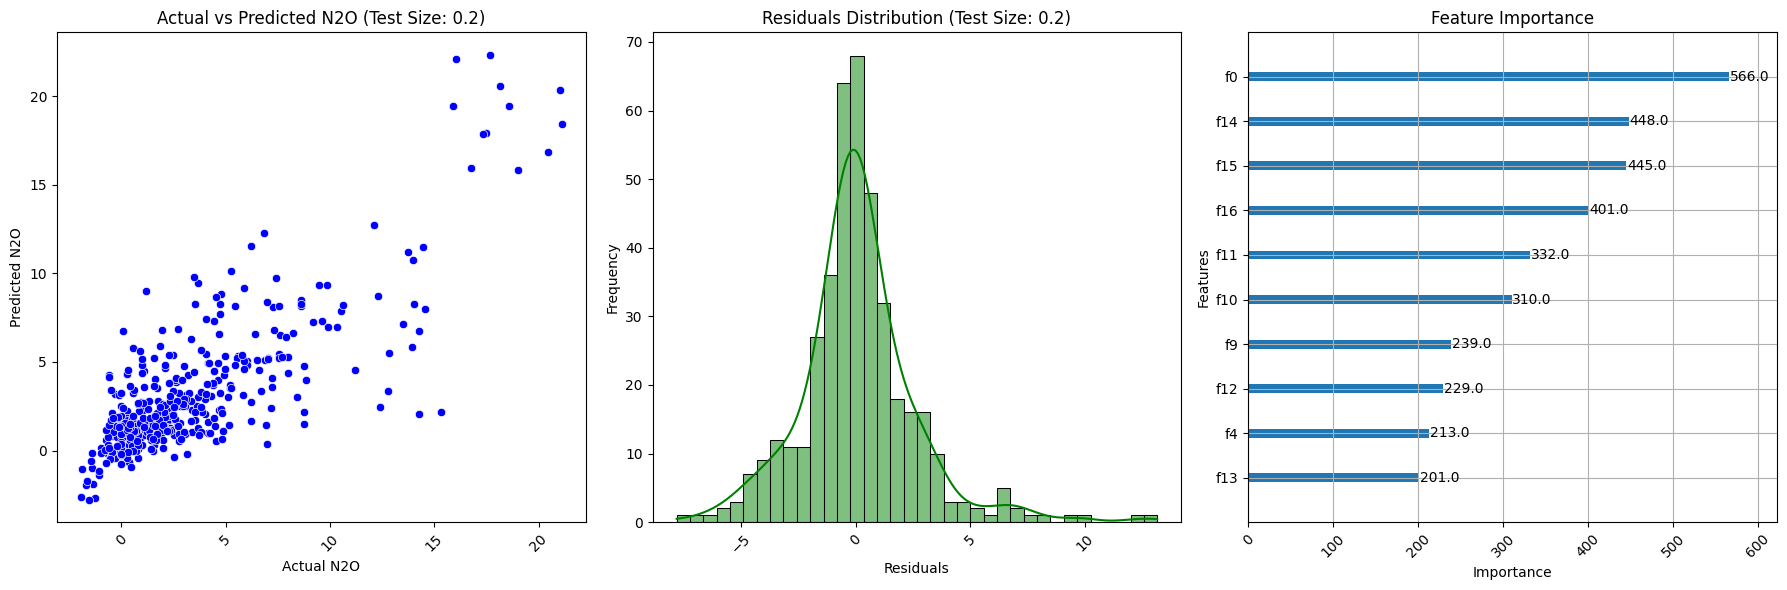

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.25
Mean Squared Error: 6.8703497053095575
Root Mean Squared Error: 2.62113519401605
Mean Absolute Error: 1.8153531356167323
R-squared: 0.607466559430857


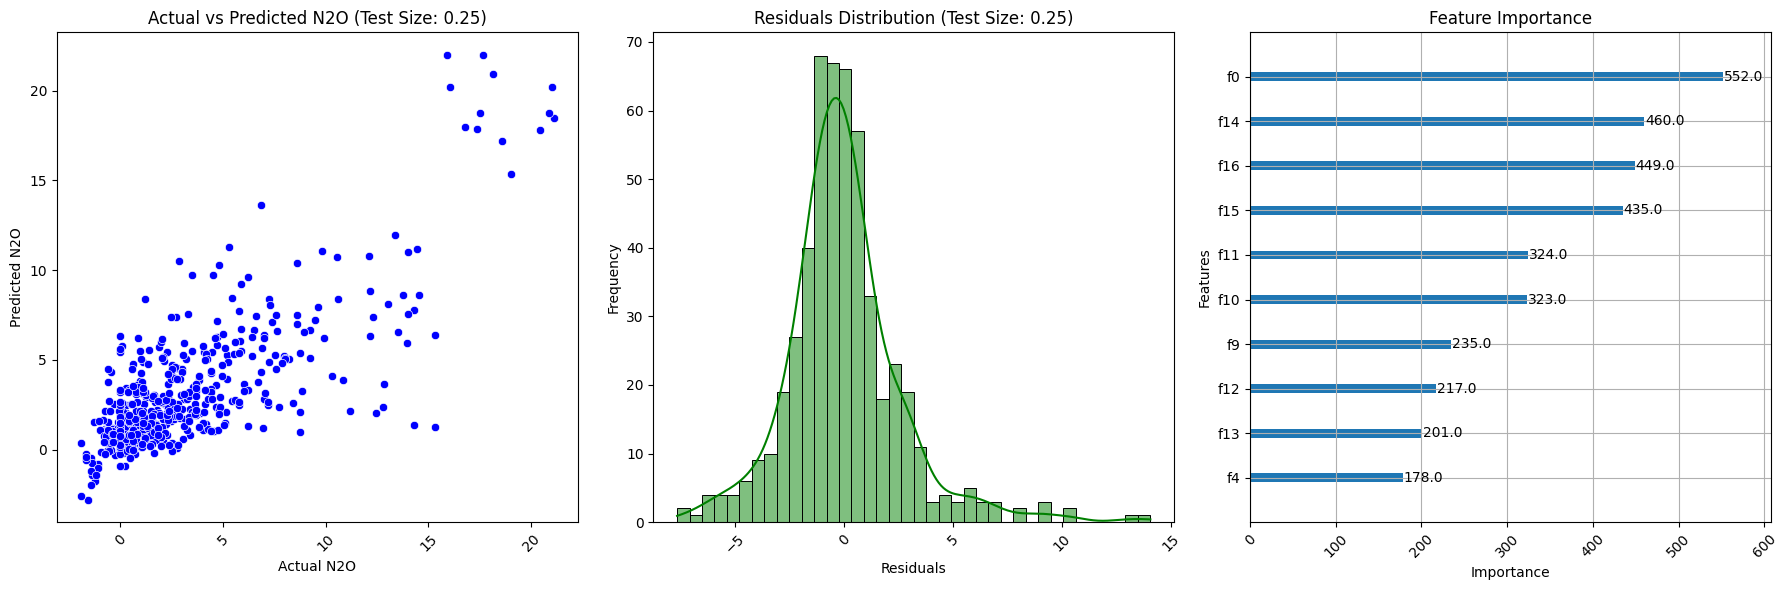

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.3
Mean Squared Error: 6.444760713799277
Root Mean Squared Error: 2.5386533268249285
Mean Absolute Error: 1.7454914015029237
R-squared: 0.614602712385986


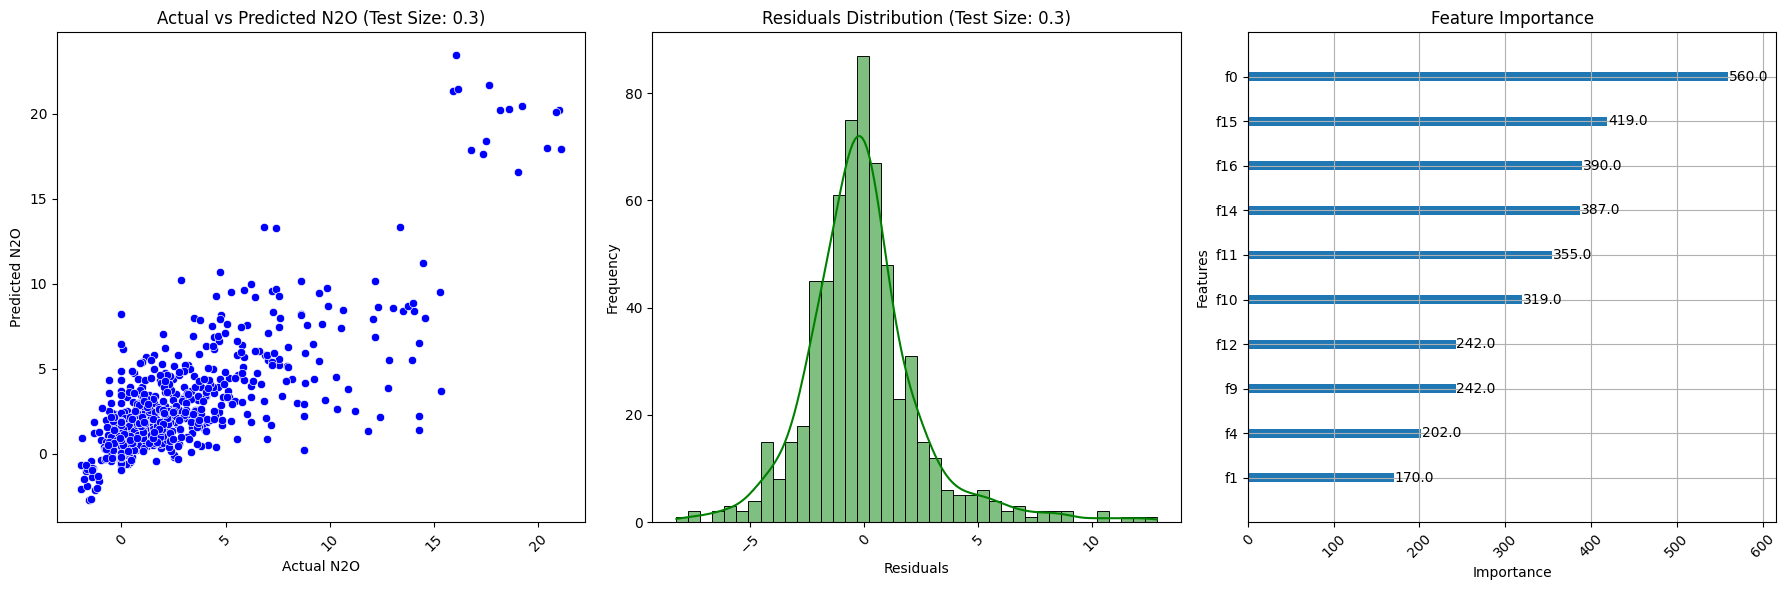

c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test Size: 0.35
Mean Squared Error: 6.976570707525591
Root Mean Squared Error: 2.6413198798187225
Mean Absolute Error: 1.8185957799326642
R-squared: 0.5690857817231034


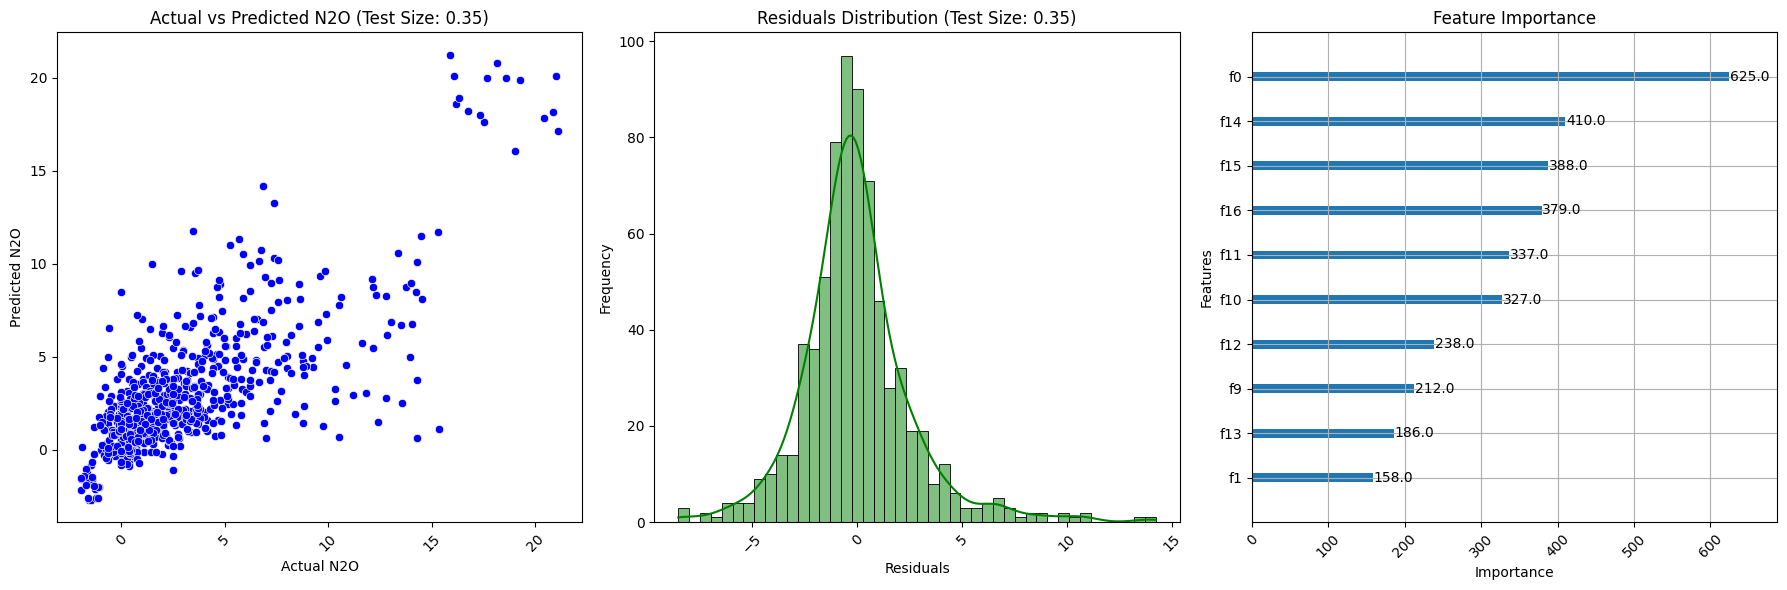

In [11]:
test_sizes = [0.2,0.25, 0.3, 0.35]
results = {}
# Initialize an empty list to store results
evaluation = []
for test_size in test_sizes:
    model, mse, rmse, mae, r2 = train_and_evaluate(test_size)
    results[test_size] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}
    evaluation.append({
        'test_size': test_size,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    })


In [12]:
# Convert results to a DataFrame
eval_df = pd.DataFrame(evaluation)

# Save the results to a CSV file
eval_df.to_csv('dataset/0906_1_xgboost_evaluation_datauji_plain_nooutliers_results_IDO_NoCV.csv', index=False)
eval_df

,test_size,mse,rmse,mae,r2
0,0.20,6.446511,2.538998,1.723013,0.643607
1,0.25,6.870350,2.621135,1.815353,0.607467
2,0.30,6.444761,2.538653,1.745491,0.614603
3,0.35,6.976571,2.641320,1.818596,0.569086


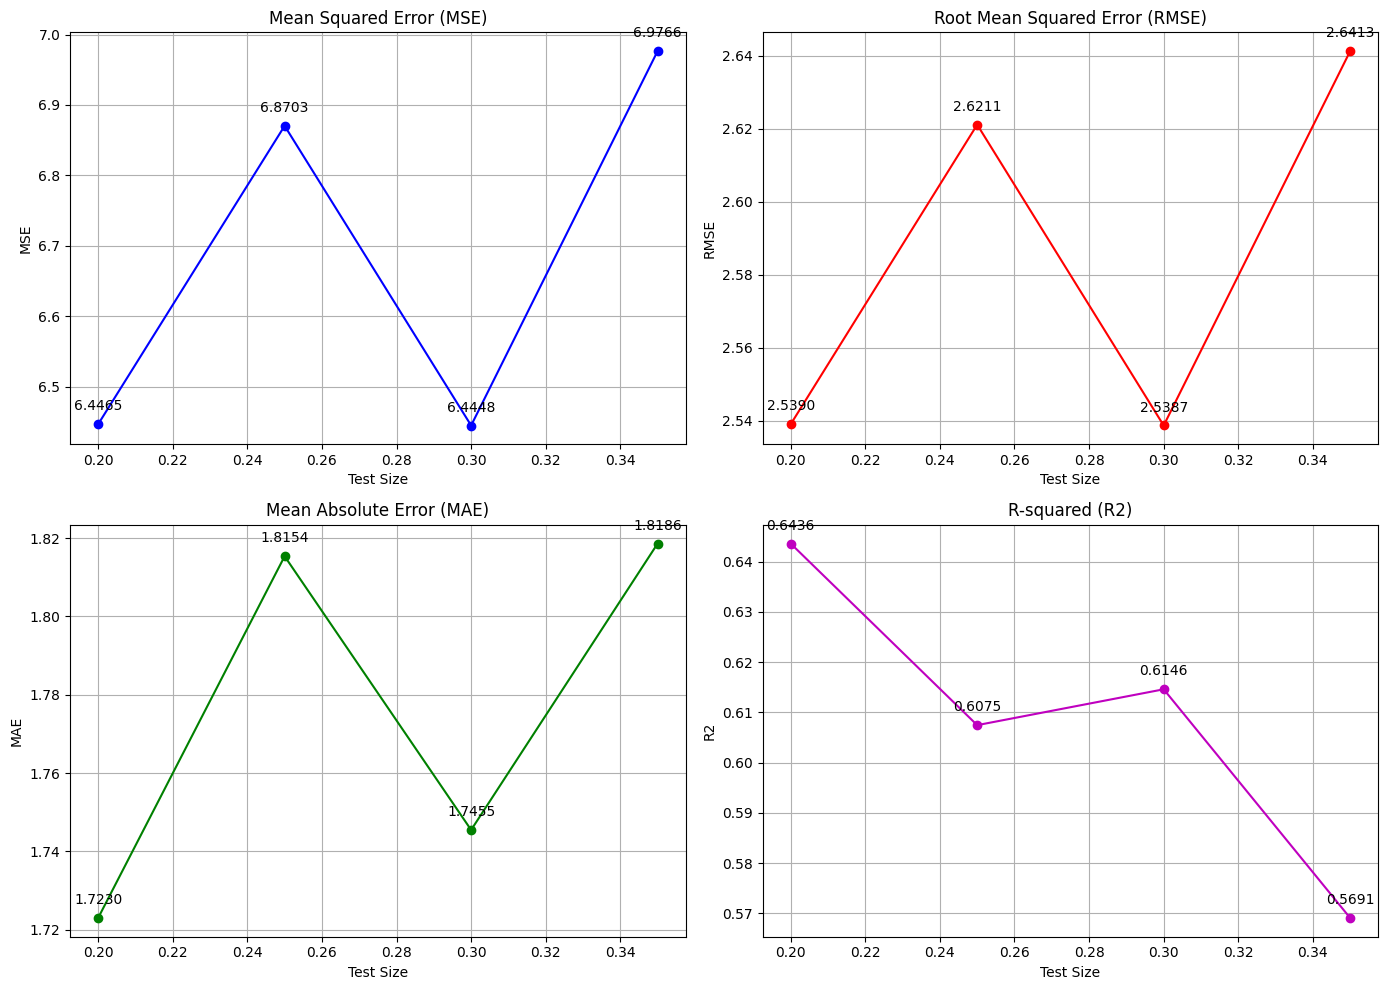

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new dataset
# data = pd.read_csv('/mnt/data/0906_1_xgboost_evaluation_datauji_plain_nooutliers_results_IDO_NoCV.csv')

# Extracting columns for visualization
test_size = eval_df['test_size']
mse = eval_df['mse']
rmse = eval_df['rmse']
mae = eval_df['mae']
r2 = eval_df['r2']

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
axes[0, 0].plot(test_size, mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(mse):
    axes[0, 0].annotate(f'{txt:.4f}', (test_size[i], mse[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_xlabel('Test Size')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].grid(True)

# Plot RMSE
axes[0, 1].plot(test_size, rmse, marker='o', linestyle='-', color='r')
for i, txt in enumerate(rmse):
    axes[0, 1].annotate(f'{txt:.4f}', (test_size[i], rmse[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_xlabel('Test Size')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True)

# Plot MAE
axes[1, 0].plot(test_size, mae, marker='o', linestyle='-', color='g')
for i, txt in enumerate(mae):
    axes[1, 0].annotate(f'{txt:.4f}', (test_size[i], mae[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_xlabel('Test Size')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].grid(True)

# Plot R2
axes[1, 1].plot(test_size, r2, marker='o', linestyle='-', color='m')
for i, txt in enumerate(r2):
    axes[1, 1].annotate(f'{txt:.4f}', (test_size[i], r2[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[1, 1].set_title('R-squared (R2)')
axes[1, 1].set_xlabel('Test Size')
axes[1, 1].set_ylabel('R2')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


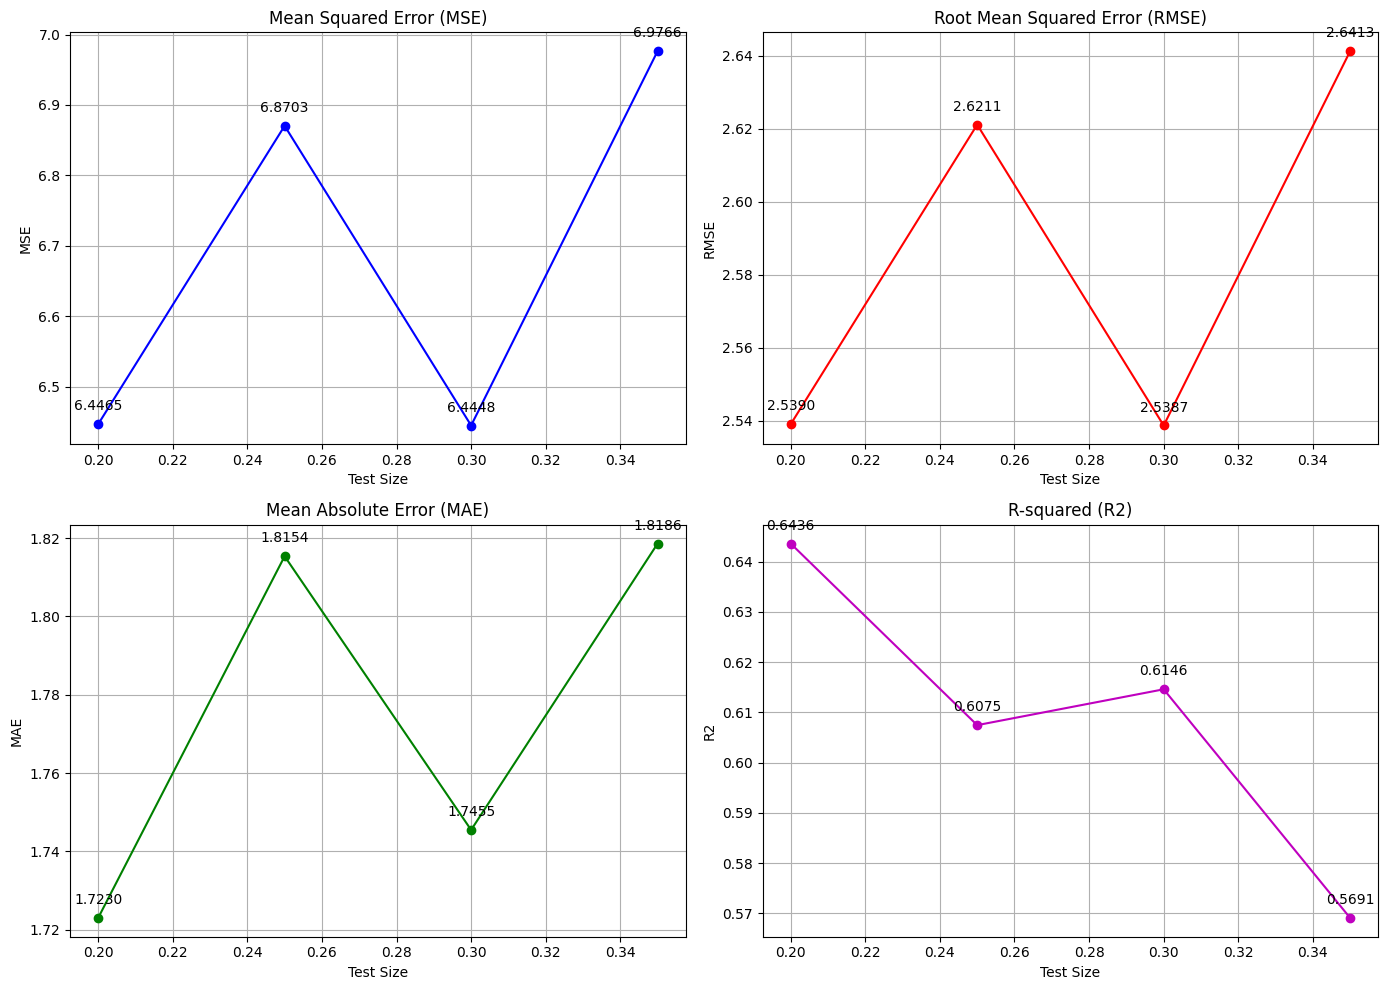

In [15]:
# import matplotlib.pyplot as plt

# # Data
test_size = [0.2, 0.25, 0.3, 0.35]
# mse = [6.4465, 6.8703, 6.4448, 6.9766]
# rmse = [2.5390, 2.6211, 2.5387, 2.6413]
# mae = [1.7230, 1.8154, 1.7455, 1.8186]
# r2 = [0.6436, 0.6075, 0.6146, 0.5691]

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot MSE
axes[0, 0].plot(test_size, mse, marker='o', linestyle='-', color='b')
for i, txt in enumerate(mse):
    axes[0, 0].annotate(f'{txt:.4f}', (test_size[i], mse[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[0, 0].set_title('Mean Squared Error (MSE)')
axes[0, 0].set_xlabel('Test Size')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].grid(True)

# Plot RMSE
axes[0, 1].plot(test_size, rmse, marker='o', linestyle='-', color='r')
for i, txt in enumerate(rmse):
    axes[0, 1].annotate(f'{txt:.4f}', (test_size[i], rmse[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
axes[0, 1].set_xlabel('Test Size')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True)

# Plot MAE
axes[1, 0].plot(test_size, mae, marker='o', linestyle='-', color='g')
for i, txt in enumerate(mae):
    axes[1, 0].annotate(f'{txt:.4f}', (test_size[i], mae[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[1, 0].set_title('Mean Absolute Error (MAE)')
axes[1, 0].set_xlabel('Test Size')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].grid(True)

# Plot R2
axes[1, 1].plot(test_size, r2, marker='o', linestyle='-', color='m')
for i, txt in enumerate(r2):
    axes[1, 1].annotate(f'{txt:.4f}', (test_size[i], r2[i]), textcoords="offset points", xytext=(0,10), ha='center')
axes[1, 1].set_title('R-squared (R2)')
axes[1, 1].set_xlabel('Test Size')
axes[1, 1].set_ylabel('R2')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()
